In [1]:
!pip3 install pystan prophet

In [18]:
import pandas as pd
from prophet import Prophet
from datetime import datetime

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
print(df['Product'].unique())
print(df['Store'].unique())

[2667437]
['QLD_CW_ST0203']


In [5]:
df['Year'] = df['Time Date'].apply(lambda x: str(x)[-4:])
df['Month'] = df['Time Date'].apply(lambda x: str(x)[-6:-4])
df['Day'] = df['Time Date'].apply(lambda x: str(x)[:-6])
df['ds'] = pd.DatetimeIndex(df['Year'] + '-' + df['Month'] + '-' + df['Day'])
df.dtypes

Time Date             int64
Product               int64
Store                object
Value               float64
Year                 object
Month                object
Day                  object
ds           datetime64[ns]
dtype: object

In [6]:
df.drop(['Time Date', 'Product', 'Store', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.columns = ['y', 'ds']

df.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


# Training

## 1.  Uncertainty

- `interval_width=0.95` -> handles trend uncertainty (as opposed to uncertainty in seasonality)
    - by allowing higher flexibility rate, `changepoint_prior_scale`, we also increase the forecast uncertainty
    - This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting
    

- Uncertainty in seasonality/parameter uncertainty: to get uncertainty in seasonality, you must do full Bayesian sampling (Stan):
    - `m = Prophet(mcmc_samples=300)`
    - This replaces the typical MAP estimation with MCMC sampling
    
 Question: Why don't autoregressive models have uncetainty but "explicitly evolve in time" (see https://www.youtube.com/watch?v=OaTAe4W9IfA)

In [7]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(df)

Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1946.15    0.00154934       81.6896      0.8003      0.8003      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       1946.18   0.000238115       88.2856   2.661e-06       0.001      161  LS failed, Hessian reset 
     199       1946.24   0.000566946       86.8058           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       1946.38   0.000696341       83.5831   7.989e-06       0.001      344  LS failed, Hessian reset 
     299       1946.44   2.57067e-05       89.0436     0.02439      0.2163      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       1946.45   5.77081e-06       56.0772   1.023e-07       0.001      607  LS failed, Hessian rese

     62.1522      0.3861      0.3861      652   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     402       1946.45   2.81054e-07       40.8974      0.7537      0.7537      655   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


## Forecast

In [8]:
future = m.make_future_dataframe(periods=365,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,3041.090656,816.730037,3880.033415,3041.090656,3041.090656,-643.078244,-643.078244,-643.078244,466.298831,...,16.629586,16.629586,16.629586,-1126.006661,-1126.006661,-1126.006661,0.0,0.0,0.0,2398.012413
1,2018-01-02,3041.861642,893.440008,4025.649293,3041.861642,3041.861642,-653.110974,-653.110974,-653.110974,466.298831,...,-11.277476,-11.277476,-11.277476,-1108.132329,-1108.132329,-1108.132329,0.0,0.0,0.0,2388.750668
2,2018-01-03,3042.632627,890.204260,3989.152071,3042.632627,3042.632627,-627.189373,-627.189373,-627.189373,466.298831,...,-4.409574,-4.409574,-4.409574,-1089.078630,-1089.078630,-1089.078630,0.0,0.0,0.0,2415.443254
3,2018-01-04,3043.403613,760.342182,3980.159876,3043.403613,3043.403613,-580.147667,-580.147667,-580.147667,466.298831,...,22.476339,22.476339,22.476339,-1068.922836,-1068.922836,-1068.922836,0.0,0.0,0.0,2463.255946
4,2018-01-05,3044.174598,757.460045,3985.155691,3044.174598,3044.174598,-616.082261,-616.082261,-616.082261,466.298831,...,-34.586261,-34.586261,-34.586261,-1047.794831,-1047.794831,-1047.794831,0.0,0.0,0.0,2428.092337


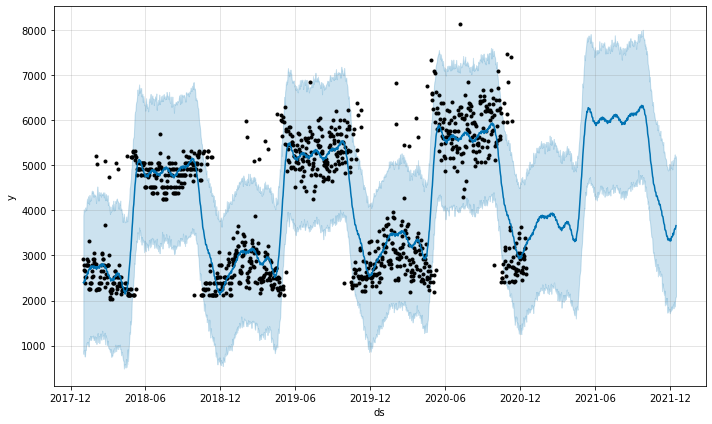

In [9]:
plot1 = m.plot(forecast)

Multiple seasonalities are handled with Fourier:

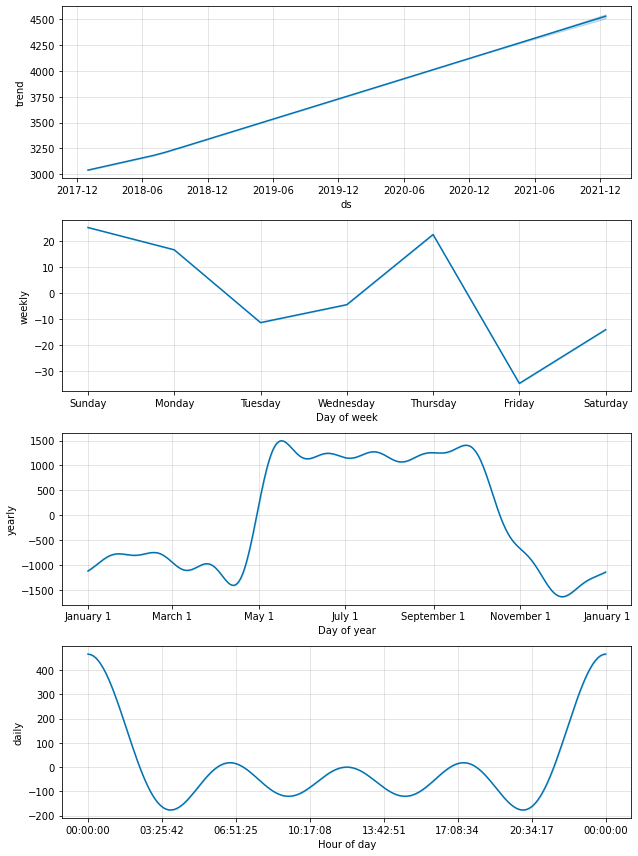

In [10]:
# Seasonality by timeframe
plt2 = m.plot_components(forecast)

# 2. Trend changepoints

Changepoints: abrupt changes in timeseries trajectory. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. 

- Since prophet is using regression on timeseries, the automatic detection is done with L1-regularization

However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history):

`m = Prophet(changepoint_range=0.9)` - Changepoints are only inferred for the first 90% of the time series. Default is 80% (in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series).

`m = Prophet(changepoint_prior_scale=0.5)` - default is 0.05. Adjusting the strength of the sparse prior if the model is overfitting (too much flexibility) or underfitting (not enough flexibility).

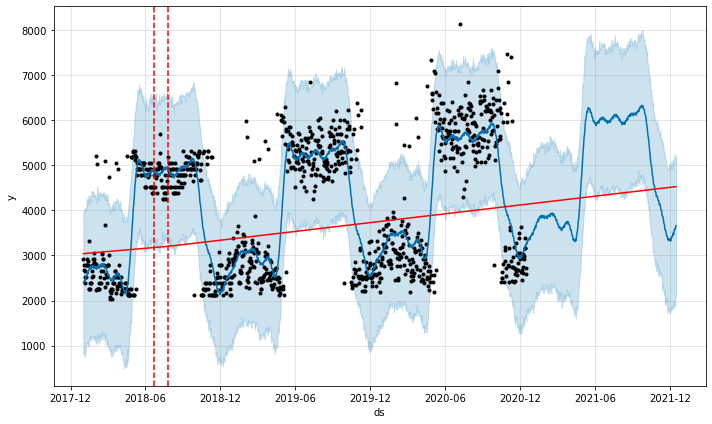

In [11]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## 2.1 Adjusting changepoint range

Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1946.14   0.000244114       86.5531           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1946.35    4.5714e-06       63.0264           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1946.35   9.67108e-08        53.485      0.2631           1      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


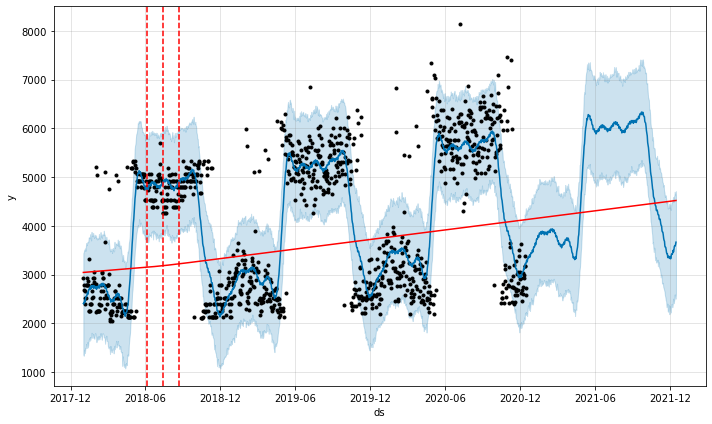

In [12]:
m = Prophet(changepoint_range=0.9, daily_seasonality=True)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       1946.03   0.000244054        122.83   1.568e-06       0.001      170  LS failed, Hessian reset 
      99       1946.11   0.000167674        62.497      0.9214      0.9214      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       1946.23   0.000611931       202.886   5.023e-06       0.001      320  LS failed, Hessian reset 
     199       1946.31   6.20672e-06       73.4458           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       1946.31   8.68134e-06       92.4543   1.124e-07       0.001      453  LS failed, Hessian reset 
     263       1946.31   1.73275e-08       68.4111     0.04023           1      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

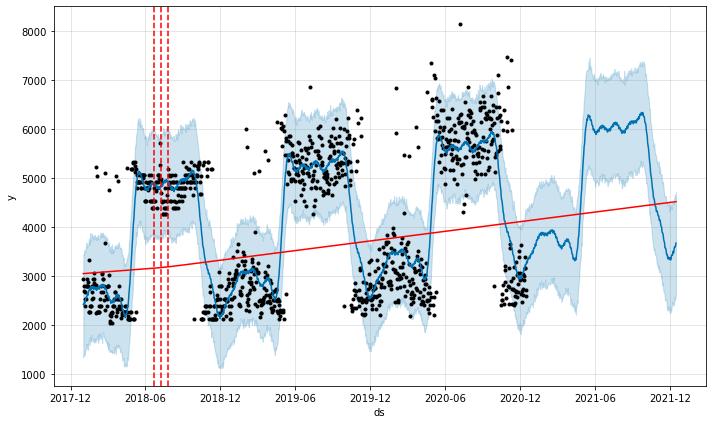

In [13]:
m = Prophet(changepoint_range=0.4, daily_seasonality=True)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## 2.2 Adjusting trend flexibility (_changepoint_prior_scale_)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       1903.65   1.95381e-05       4888.95   4.006e-09       0.001      120  LS failed, Hessian reset 
      99       1903.72   1.71229e-08        5037.8           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1903.72   5.98432e-09       4905.65      0.6761      0.6761      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


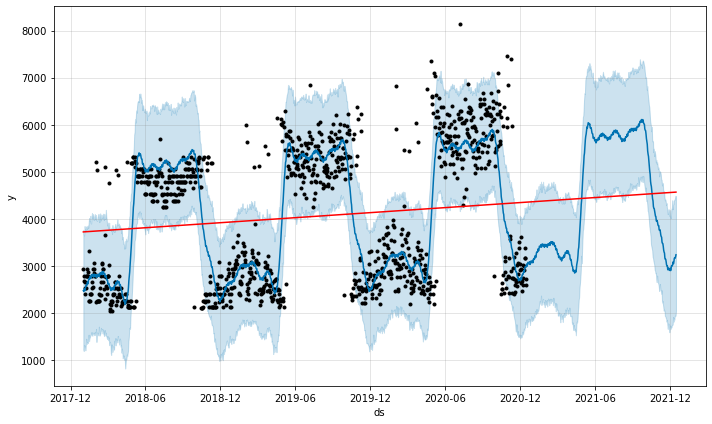

In [14]:
m = Prophet(changepoint_prior_scale=0.001)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1948.68   0.000940529       14.4398      0.4958      0.4958      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1948.87   0.000182011       8.07373           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1948.93   9.49312e-05       5.56205        1.43       0.143      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       1948.97   0.000657992       28.0675   9.685e-05       0.001      495  LS failed, Hessian reset 
     399       1948.98   1.72281e-05       7.17165      0.5558      0.5558      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       1948.98   8.20124e-07    

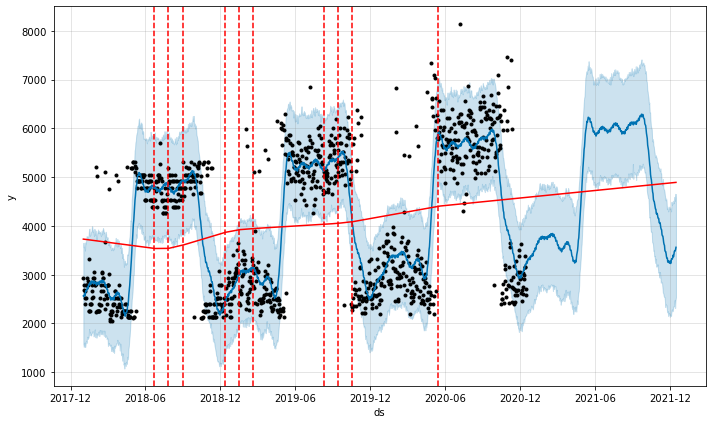

In [15]:
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# 3. Seasonality, Holiday Effects, And Regressors

## 3.1 Holiday Effects

- Include dataframe with all past occurences of the holiday and future (as far as you're predicting)
    - `[holiday, ds]`
    - `[lower_window, upper_window]` - i.e. if we are modeling Christmas, `lower_window = -1` and `upper_window = 0` because of Christmas Eve

In [16]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2017-01-6', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

m = Prophet(holidays=holidays)
forecast = m.fit(df).predict(future)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       1945.53    0.00063188       102.445   3.994e-06       0.001      108  LS failed, Hessian reset 
      99       1946.08   0.000572624       68.8129      0.3795      0.9874      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       1946.16   0.000234519       56.5622   2.236e-06       0.001      207  LS failed, Hessian reset 
     199        1946.2   0.000212579       65.1217      0.5217      0.5217      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1946.43    1.0324e-05       75.5645       1.405      0.1405      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       1946.43   3.86535e-06       39.9826    5.52e-08       0.001      523  LS failed, Hessian rese

In [17]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
